In [1]:
import glob
import os
import pickle
import numpy as np
import pandas as pd
# import scanpy as sc
import tqdm
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import issparse


In [3]:
def top_predictable_genes(df_results: pd.DataFrame, dataset: str, method: str, num: int = 5) -> pd.DataFrame:
    """
    Extracts the top predictable genes based on Pearson correlation for a specific method and dataset.

    Parameters:
        - df_results (pd.DataFrame): The DataFrame containing the results from the make_res function.
        - dataset (str): The dataset name.
        - method (str): The method name.
        - num (int, optional): The number of top predictable genes or "pos" for all positive Pearson correlation values.

    Returns:
        pd.DataFrame: DataFrame containing the top predictable genes and related statistics.
    """
    df = df_results[df_results["Method"] == method]

    if num == "pos":
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False)
    else:
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)

    top_genes = list(top_df.index)

    # Calculate the number of consistent samples for each top gene
    num_pos = [df[df["Gene"] == g]['Pearson correlation'].gt(0).sum() for g in top_genes]

    # Create the final DataFrame with relevant columns
    top_df["Number of consistent samples"] = num_pos
    top_df["Method"] = method
    top_df["Dataset"] = dataset
    top_df = top_df[[('Method', ''), ('Dataset', ''), ('Number of consistent samples', ''),
                     ('Pearson correlation', 'mean'), ('Pearson correlation', 'median'),
                     ('Pearson correlation', 'min'), ('Pearson correlation', 'max'),
                     ('Pearson correlation', 'std')]]

    return top_df

In [4]:
# Specify the directory where CSV files are located
results_directory = "../Results/Summary/"

# Use os.path.join for path construction
csv_files = glob.glob(os.path.join(results_directory, '*_summary_MI_hvg.csv'))

# Use tqdm to add a progress bar during concatenation
dfs = []
for csv_file in tqdm.tqdm(csv_files, desc='Reading CSV files', unit='file'):
    df = pd.read_csv(csv_file, index_col=[0])
    dfs.append(df)

# Concatenate all DataFrames into one
df = pd.concat(dfs, ignore_index=True)

# Display the concatenated DataFrame
df.head()


Reading CSV files: 100%|██████████| 6/6 [00:00<00:00,  9.17file/s]


,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method
0,0,WSB1,0.080830,3.681056e-05,0.091596,3.488596e-06,0.060802,0.684259,0.049854,CID4290,BC_visium,deepspace
1,1,MTUS1,0.049292,7.867436e-03,0.055584,3.227185e-03,0.042992,0.537210,0.038030,CID4290,BC_visium,deepspace
2,2,PATJ,-0.019836,8.343135e-01,0.002619,4.489841e-01,-0.004087,0.440835,-0.004568,CID4290,BC_visium,deepspace
3,3,ORAI2,0.000563,4.890120e-01,0.021852,1.422872e-01,0.009482,0.383502,0.001158,CID4290,BC_visium,deepspace
4,4,TGFB1I1,0.155290,1.004125e-14,0.151771,3.869639e-14,0.091739,0.553297,0.107432,CID4290,BC_visium,deepspace


In [5]:
# Define mapping dictionaries for model and dataset names
model_mapping = {
    'deeppt': "DeepPT",
    'histogene': "HisToGene",
    'His2gene': "HisToGene",
    'stnet': "STnet",
    'hist2st': "Hist2ST",
    'stimage': "STimage",
    'bleep': "BLEEP",
    'deepspace': "DeepSpaCE"
}

dataset_mapping = {
    'SCC_Chenhao': "Skin_Melanoma",
    'Skin_cscc': "Skin_cSCC",
    'Liver_bleep': "Liver_Visium",
    'Liver_visium': "Liver_Visium",
    'BC_visium': "BC_Visium",
    'Kidney_visium': "Kidney_Visium"
}

# Replace model and dataset names in the DataFrame
df.replace({'Method': model_mapping, 'Dataset': dataset_mapping}, inplace=True)

# Define the order for Dataset and Method columns
dataset_order = ['BC_Her2ST', 'BC_Visium', 'Skin_cSCC', 'Skin_Melanoma', 'Kidney_Visium', 'Liver_Visium']
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

# Use pd.Categorical directly during DataFrame creation
df['Dataset'] = pd.Categorical(df['Dataset'], categories=dataset_order, ordered=True)
df['Method'] = pd.Categorical(df['Method'], categories=method_order, ordered=True)


In [5]:
# df.to_csv("../Results/Summary/summary_MI_hvg.csv")

In [6]:
def set_ymargin(ax, left=0.0, right=0.3):
    ax.set_ymargin(0)
    ax.autoscale_view()
    lim = ax.get_ylim()
    delta = np.diff(lim)
    # delta = 1
    left = lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_ylim(left,right)

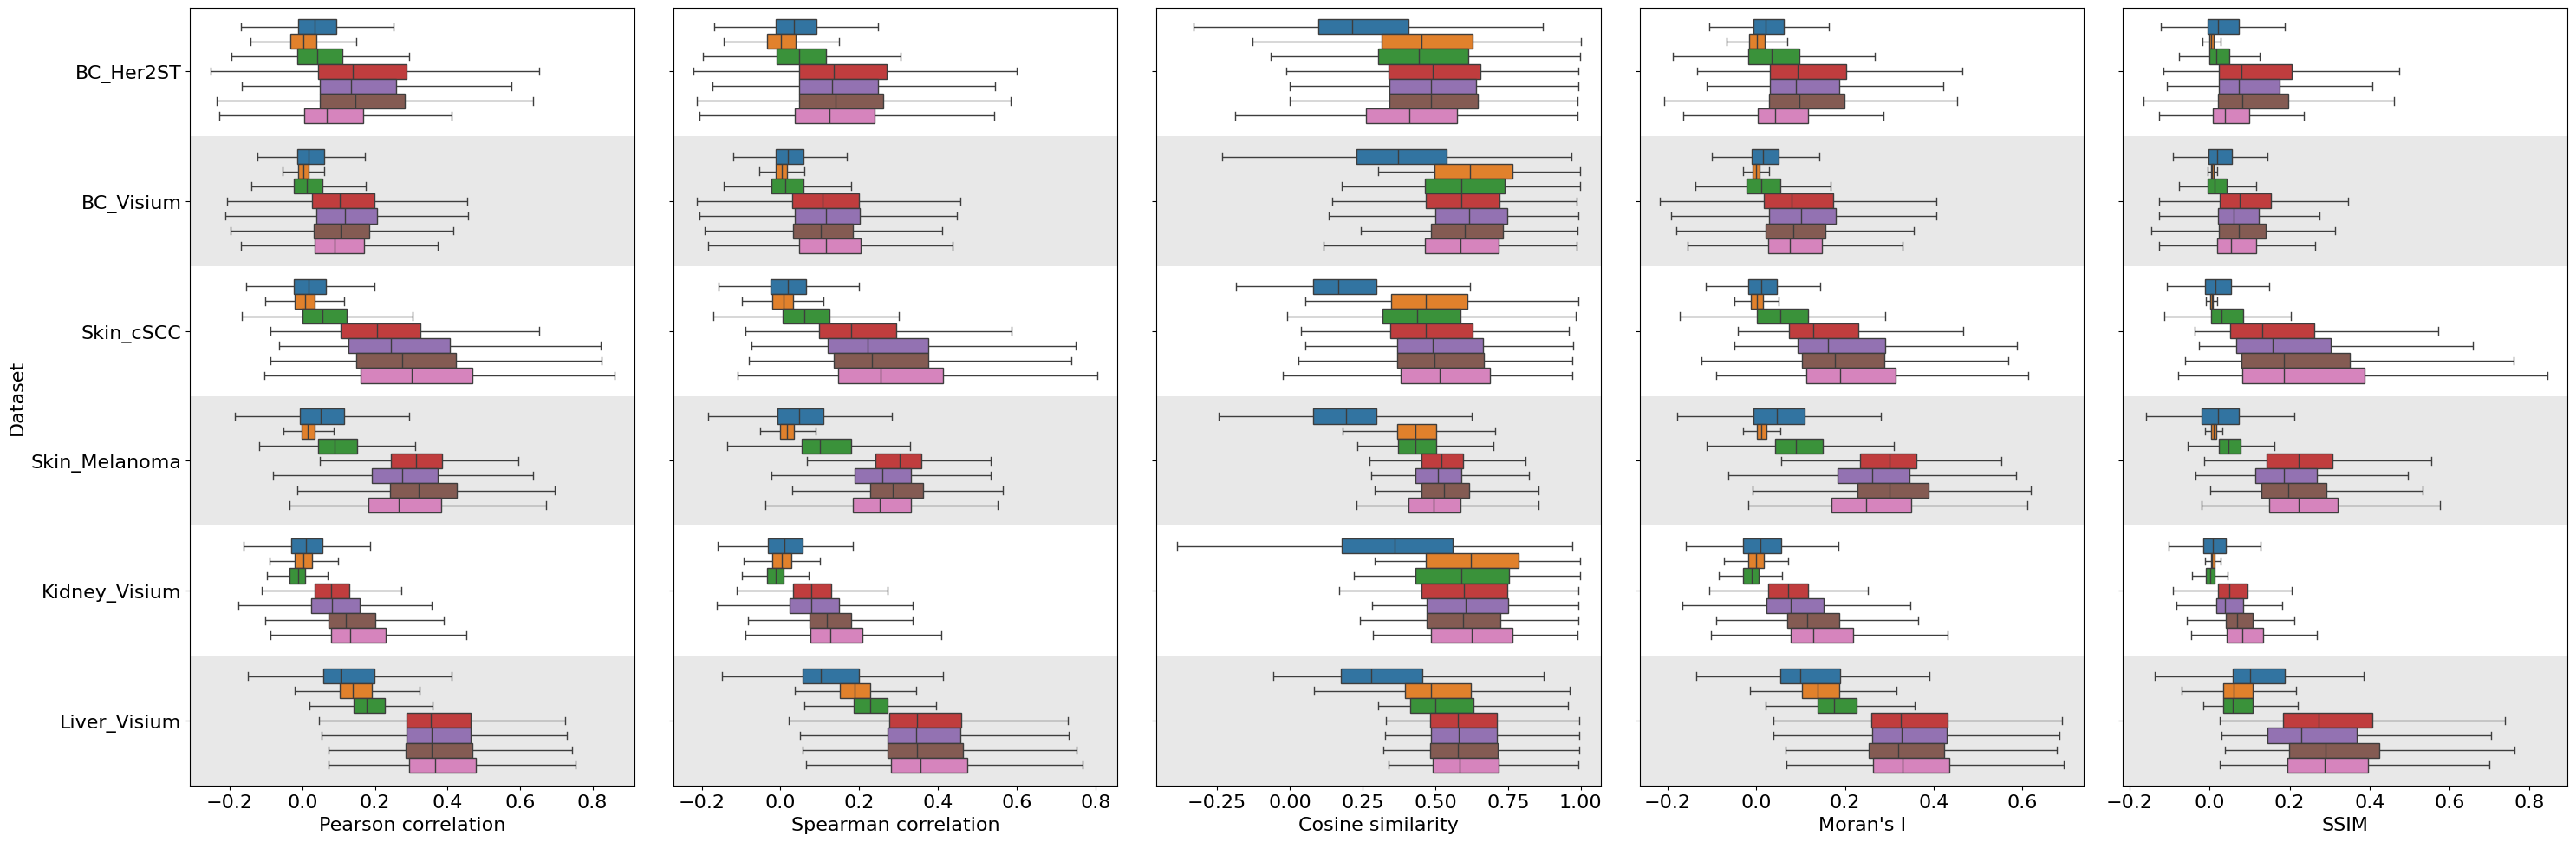

911

In [7]:
# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with 4 rows and 1 column
fig, axs = plt.subplots(1, 5, figsize=(30, 10))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', False),
    ('Spearmanr correlation', 'Spearman correlation', False),
    ('Cosine_Score', 'Cosine similarity', False),
    ("Moran'I_Score", "Moran's I", False),
    ('SSIM_Score', 'SSIM', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    # sns.boxplot(x='Dataset', y=column, hue='Method', data=df, ax=axs[i], showfliers=False)
    sns.boxplot(x=column, y='Dataset', hue='Method', data=df, ax=axs[i], showfliers=False)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[i].get_legend().remove()
    
    # axs[i].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[i].set_xlabel(ylabel)
    if i>0:
        axs[i].set_ylabel('')  # Remove x label for all subplots
for ax in axs[1:]:
    # ax.sharex(axs[0])
    ax.set_yticklabels([])

# Move the legend outside the plot area only for the first subplot
# pos = axs[0].get_position()
# axs[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
# axs[0].legend(
#     loc='upper center',
#     bbox_to_anchor=(0.5, 1.2),
#     ncol=7,
# )

for ax in axs:
    ax.axhspan(0.5,1.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(2.5,3.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(4.5,5.5, facecolor='lightgray', alpha=0.5)
    set_ymargin(ax, left=0, right=0.015)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
# plt.savefig("Figure_S1.pdf")

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()


In [8]:
import pickle
with open('/scratch/user/uqjxie6/DeepHis2Exp/Figures/fighvgs.pkl', 'wb') as file:
    pickle.dump(df, file)